In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import openflash
from scipy.special import hankel1e 
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_constants import rho #need for BEM

import time
from capytaine_generator import CapytaineSlantSolver
import capytaine as cpt
import sys
import os

# Define the path to the directory containing the package
utils_path = r"C:\Users\15183\OpenFLASH\sea-lab-utils"

if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import from the folder structure
# Assuming 'pyplotutilities' is a folder inside 'sea-lab-utils'
from pyplotutilities import colors
from pyplotutilities import fonts
colors.get_colors()
print(colors.purple)
fonts.get_fonts()

<class 'module'>
['C:\\Users\\15183\\OpenFLASH\\package\\src\\openflash']
C:\Users\15183\OpenFLASH\package\src\openflash\__init__.py
OpenFLASH modules imported successfully!
#CC79A7


In [2]:
css = CapytaineSlantSolver(True, True, False, False, False)
def compute_cpt_slant(config):
  t_densities = [30, 50]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 30, config["h"], config["omega"], config["rho"], 1)
  # t_densities = [80, 100]
  # respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 80, config["h"], config["omega"], config["rho"], 1)
  am, dp, f_ex = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"], (cpt.assemble_dataset([respack[2]]))["excitation_force"][0][0][0].values
  return am, dp, f_ex

In [3]:
from openflash.multi_equations import wavenumber

wavenumber(1.2,100)

np.float64(0.14678899082574026)

In [ ]:
def MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list):

    A_MEEM = np.zeros_like(omega_sweep)
    B_MEEM = np.zeros_like(omega_sweep)
    F_ex_MEEM = np.zeros(len(omega_sweep), dtype=np.complex128)

    for j in range(len(omega_sweep)):
        # Run MEEM
        d_list = d_out # drafts [m] 

        # 1. Create SteppedBody objects
        bodies_sweep = []

        m0 = wavenumber(omega_sweep[j], h)
        
        # Single Body
        body = SteppedBody(
            a=np.array(a_list),
            d=np.array(d_list),
            slant_angle= np.array([0, 0]),
            heaving=heaving_list
        )
        bodies_sweep.append(body)
        

        # 2. Create arrangement
        arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

        # 3. Create geometry
        geometry_sweep = BasicRegionGeometry(
            body_arrangement=arrangement_sweep,
            h=h,
            NMK=NMK
        )

        # 4. Create the MEEMProblem instance
        problem = MEEMProblem(geometry_sweep)

        # 5. Set the frequencies for the sweep
        problem.set_frequencies(np.array([omega_sweep[j]]))

        # 6. Initialize a new MEEM Engine for this problem
        engine = MEEMEngine(problem_list=[problem])

        # 7. Solve
        X = engine.solve_linear_system_multi(problem, m0)

        # 8. Coefficients
        coeffs = engine.compute_hydrodynamic_coefficients(problem, X, m0)
        # print(coeffs[0])

        # excitation force magnituide equation
        lambda_0e = m0
        f0 = np.sinh(2*lambda_0e*h)
        N_0 = (1/2) * (1 + (f0/(2*lambda_0e*h)))
        F_ex_MEEM[j] = ((-4 * 1j * rho * g * h * np.sqrt(N_0) * X[-NMK[-1]])/
                        (np.cosh(lambda_0e * h) *  hankel1e(0,lambda_0e * a_list[-1]) * np.exp(1j * lambda_0e * a_list[-1])) 
                         )

        
        A_MEEM[j] = coeffs[0]['real']
        B_MEEM[j] = coeffs[0]['imag']
        # F_ex_MEEM[j] = coeffs[0]['excitation_force'] * np.exp(1j * coeffs[0]['excitation_phase'])

    return A_MEEM, B_MEEM, F_ex_MEEM

In [5]:
# def MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list):
#     # Run MEEM
#     d_list = d_out # drafts [m] 

#     # 1. Create SteppedBody objects
#     bodies_sweep = []
    
#     # # Single Body
#     # body = SteppedBody(
#     #     a=np.array([a_list]),
#     #     d=np.array([d_list]),
#     #     slant_angle= np.array([[0, 0]]),
#     #     heaving=heaving_list
#     # )
#     # Single Body
#     body = SteppedBody(
#         a=np.array(a_list),
#         d=np.array(d_list),
#         slant_angle= np.array([0, 0]),
#         heaving=heaving_list
#     )
#     bodies_sweep.append(body)
    

#     # 2. Create arrangement
#     arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

#     # 3. Create geometry
#     geometry_sweep = BasicRegionGeometry(
#         body_arrangement=arrangement_sweep,
#         h=h,
#         NMK=NMK
#     )

#     # 4. Create the MEEMProblem instance
#     problem_sweep = MEEMProblem(geometry_sweep)

#     # 5. Set the frequencies for the sweep
#     problem_sweep.set_frequencies(omega_sweep)

#     # 6. Initialize a new MEEM Engine for this problem
#     engine_sweep = MEEMEngine(problem_list=[problem_sweep])

#     # --- 3.2. Run the Full Sweep ---
#     results_obj_sweep = engine_sweep.run_and_store_results(problem_index=0)
#     engine_sweep.compute_hydrodynamic_coefficients

#     # Get the xarray.Dataset
#     ds_sweep = results_obj_sweep.get_results()

#     # Extract the Added Mass and Damping matrices.
#     # These are 3D arrays: (frequency, mode_j, mode_i)
#     # A[freq, 1, 0] = Added Mass on body 1 due to motion of body 0
#     A_MEEM = ds_sweep.added_mass.values
#     B_MEEM = ds_sweep.damping.values
#     print(dir(results_obj_sweep))
#     return A_MEEM, B_MEEM

def BEM_hydro_coeffs(h,rho,omega_sweep,d_in,d_out,a_list):
    # Run BEM
    heaving_list = [1, 1]
    A_BEM = np.zeros_like(omega_sweep)
    B_BEM = np.zeros_like(omega_sweep)
    F_ex_BEM = np.zeros(len(omega_sweep), dtype=np.complex128)

    for j in range(len(omega_sweep)):
        
        print(j)
        i=1
        omega = omega_sweep[j]
        config = {"name" : "config-(" + str(i) + ")",
                    "h" : h,
                    "a" : a_list,
                    "d_in" : d_in,
                    "d_out" : d_out,
                    "heaving": heaving_list,
                    "NMK" : [100, 100], #this is unused
                    "omega" : omega,
                    "rho" : rho}
        Capy_results = compute_cpt_slant(config)
        A_BEM[j] = Capy_results[0]
        B_BEM[j] = Capy_results[1]
        F_ex_BEM[j] = Capy_results[2]
    return A_BEM, B_BEM, F_ex_BEM

In [22]:
# Run 1: Non-slanted CorPower WEC

h = 50.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
d_in = [14.45, 14.45-7.32-5.08] # drafts [m]
d_out = d_in # non-slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [150, 150, 150] # number of coefficients in each region
heaving_list = True 

0


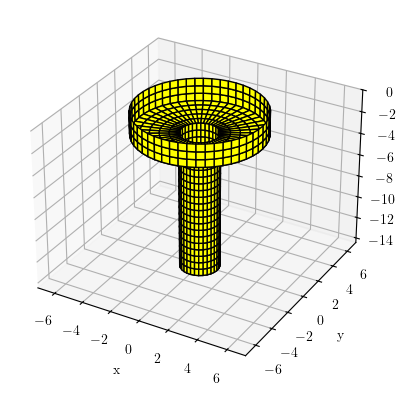

Panel Count:  1060
1


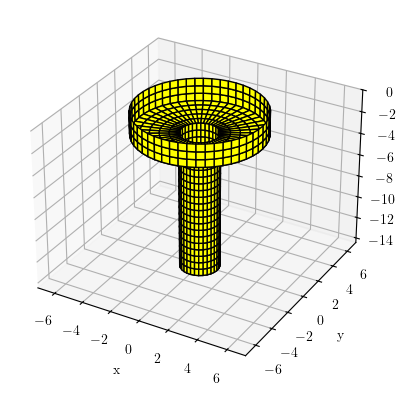

Panel Count:  1060
2


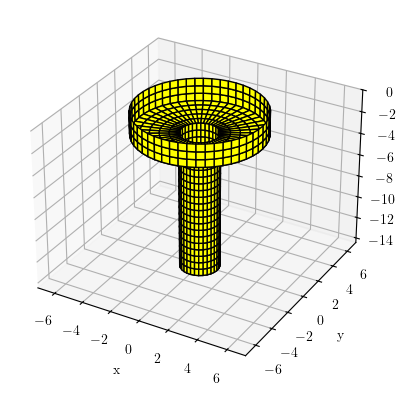

Panel Count:  1060
3


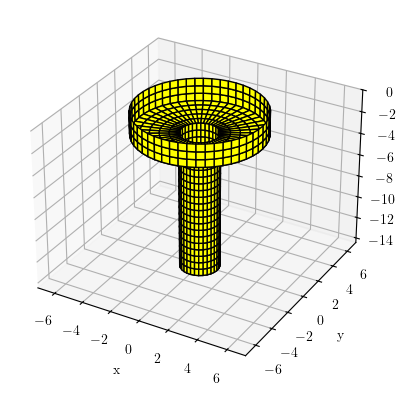

Panel Count:  1060
4


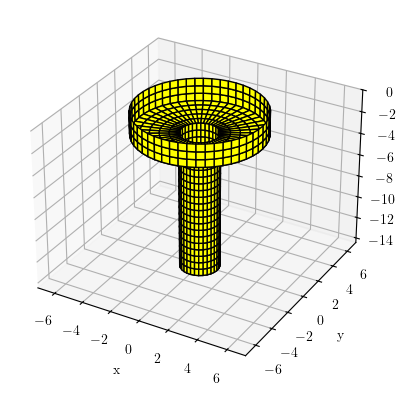

Panel Count:  1060
5


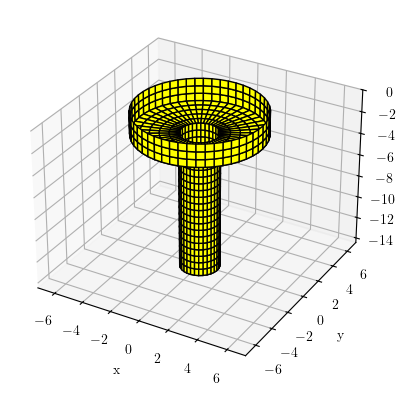

Panel Count:  1060
6


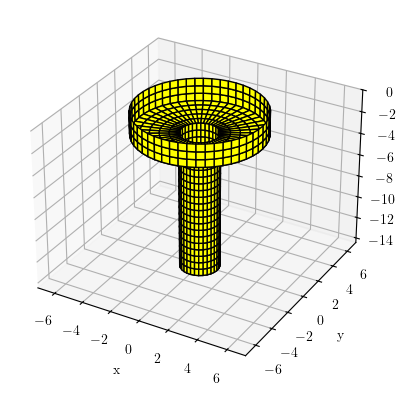

Panel Count:  1060
7


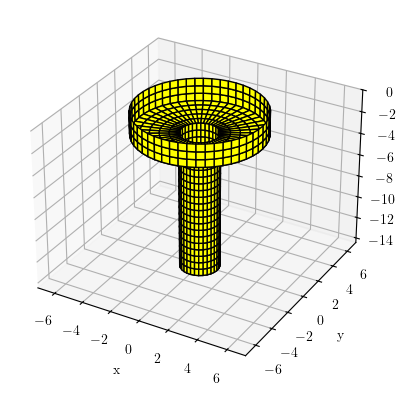

Panel Count:  1060
8


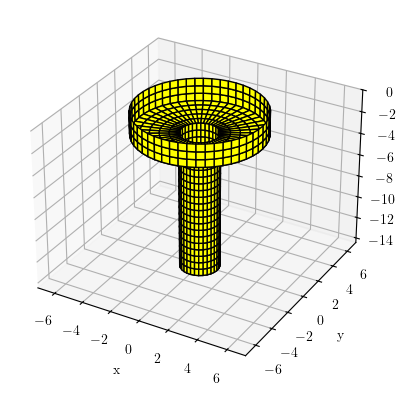

Panel Count:  1060
9


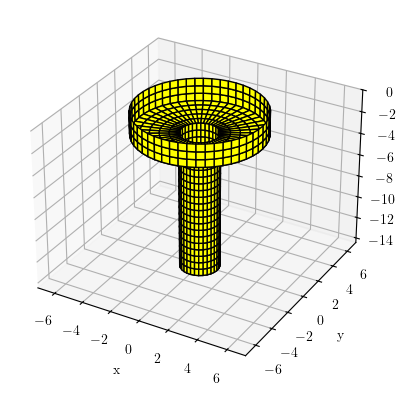

Panel Count:  1060


In [7]:
A_MEEM, B_MEEM, F_ex_MEEM = MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list)
A_BEM, B_BEM, F_ex_BEM = BEM_hydro_coeffs(h,rho,omega_sweep,d_in,d_out,a_list)


In [45]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 11 # x and y label font size
leg_fs = lab_fs  # legend font size
fig_h = 9 # figure height
fig_w = 4 # figure width



In [46]:
# Set limits of plots
x_max_lim = 1.05*np.max(omega_sweep)
x_min_lim = np.min(omega_sweep) - 0.05*np.max(omega_sweep)

A_max_lim = 1.15*np.max([A_MEEM.squeeze(),A_BEM.squeeze()])
B_max_lim = 1.05*np.max([B_MEEM.squeeze(),B_BEM.squeeze()])

In [48]:
# Function for getting coordinates of WEC geometry
def get_scaled_geom(a_list, d_in, d_out):

    RHS_coords = css.get_points(a_list, d_in, d_out)
    x_coords, y_coords = map(np.array, zip(*RHS_coords))

    x_undeformed = np.concatenate([-x_coords[::-1], x_coords])
    y_undeformed = np.concatenate([y_coords[::-1], y_coords])

    
    return x_undeformed, y_undeformed, 


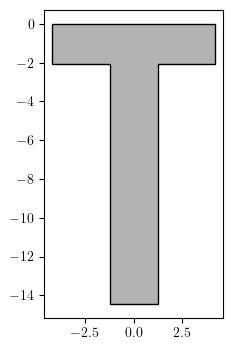

In [49]:
x_undeformed, y_undeformed = get_scaled_geom(a_list, d_in, d_out)

fig, ax = plt.subplots(figsize=(fig_h, fig_w))
ax.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
ax.set_aspect('equal')


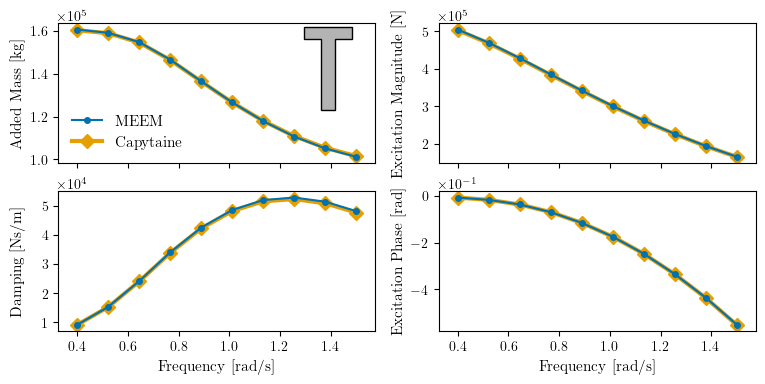

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(fig_h, fig_w), sharex=True)
for a in ax.flat:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

ax[0,0].plot(omega_sweep, 
           A_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[0,0].plot(omega_sweep, 
           A_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)

# Add schematic of geometry
ax_ins = ax[0,0].inset_axes([0.65, 0.35, 0.4, 0.65])
ax_ins.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
ax_ins.set_aspect('equal')
ax_ins.set_xticks([])
ax_ins.set_yticks([])
ax_ins.axis('off') 

ax[0,0].set_xlim([x_min_lim, x_max_lim])
ax[0,0].set_ylabel('Added Mass [kg]', fontsize=lab_fs)
ax[0,0].legend(loc='lower left', fontsize=leg_fs, frameon=False)


ax[1,0].plot(omega_sweep, 
           B_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[1,0].plot(omega_sweep, 
           B_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[1,0].set_xlim([x_min_lim, x_max_lim])
ax[1,0].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1,0].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)







ax[0,1].plot(omega_sweep, 
           np.abs(F_ex_MEEM.squeeze()),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[0,1].plot(omega_sweep, 
           np.abs(F_ex_BEM.squeeze()), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[0,1].set_ylabel('Excitation Magnitude [N]', fontsize=lab_fs)
ax[0,1].set_xlim([x_min_lim, x_max_lim])



ax[1,1].plot(omega_sweep, 
           np.angle(F_ex_MEEM.squeeze()),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[1,1].plot(omega_sweep, 
           np.angle(F_ex_BEM.squeeze()), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[1,1].set_ylabel('Excitation Phase [rad]', fontsize=lab_fs)
ax[1,1].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1,1].set_xlim([x_min_lim, x_max_lim])


fig.align_ylabels()



full_path = r"C:\Users\15183\OpenFLASH\pubs\JFM\figs\MEEM_vs_Capytaine_Nonslant_Validation.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

In [51]:
A_error = 100 * np.mean(np.abs((A_MEEM.squeeze()-A_BEM.squeeze())/A_BEM.squeeze()))
B_error = 100 * np.mean(np.abs((B_MEEM.squeeze()-B_BEM.squeeze())/B_BEM.squeeze()))
F_ex_error = 100 * np.mean(np.abs((F_ex_MEEM.squeeze()-F_ex_BEM.squeeze())/np.abs(F_ex_BEM.squeeze())))
print('Added mass is ' + str(A_error)+ ' percent off')
print('Damping is ' + str(B_error) + ' percent off')
print('Excitation force is ' + str(B_error) + ' percent off')

Added mass is 0.1503854570065082 percent off
Damping is 0.668044354123175 percent off
Excitation force is 0.668044354123175 percent off


In [55]:
# Run 2: Non-slanted complicated WEC geometry

h = 50.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
d_in = [14.45, 14.45-7.32-5.08] # drafts [m]
d_out = d_in # non-slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [150, 150, 150] # number of coefficients in each region
heaving_list = True 

In [ ]:
# Run 3: Slanted CorPower WEC

h = 50.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
d_in = [14.45, 14.45-7.32] # drafts [m]
d_out = [14.45, 14.45-7.32-5.08] # slanted version
a_list = [2.5/2, 8.4/2] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region
heaving_list = True 

0


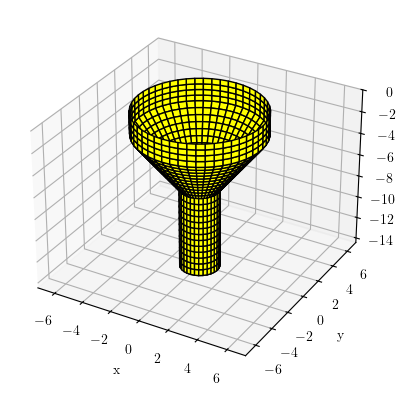

Panel Count:  1200
1


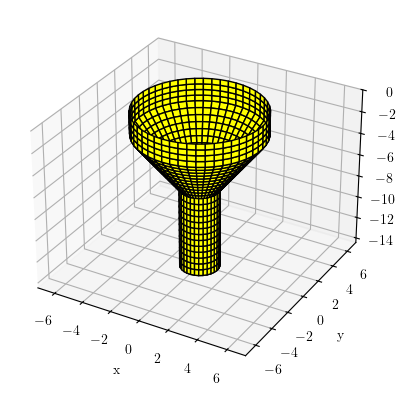

Panel Count:  1200
2


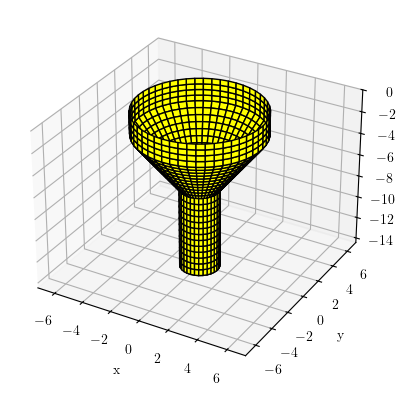

Panel Count:  1200
3


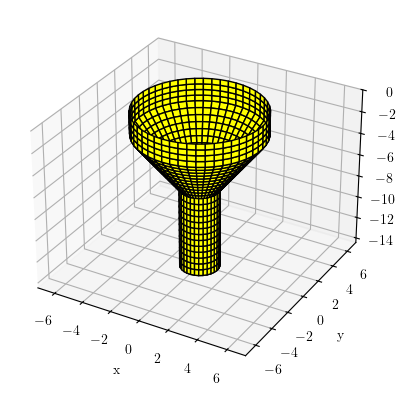

Panel Count:  1200
4


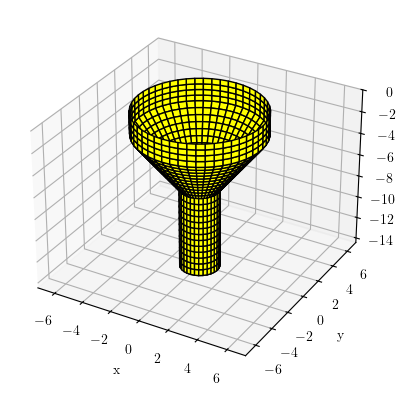

Panel Count:  1200
5


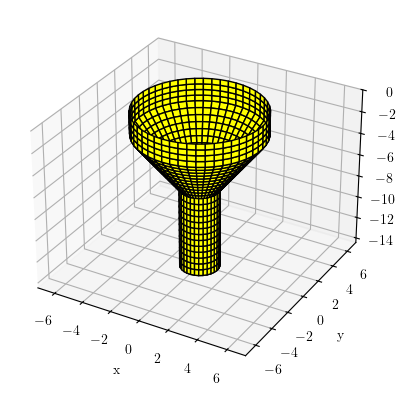

Panel Count:  1200
6


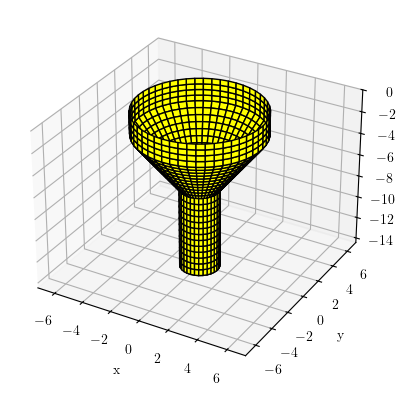

Panel Count:  1200
7


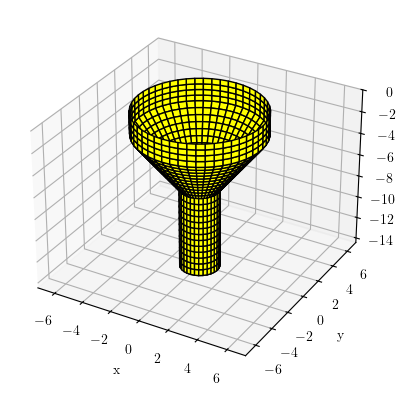

Panel Count:  1200
8


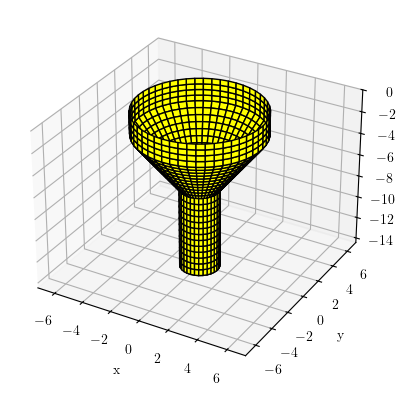

Panel Count:  1200
9


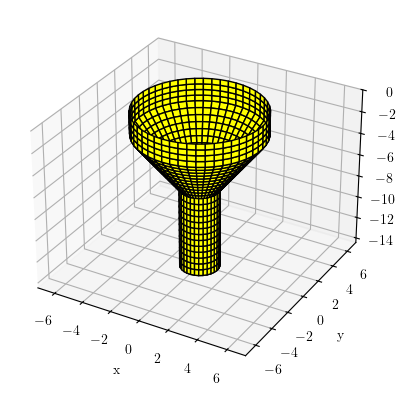

Panel Count:  1200


In [84]:
A_MEEM, B_MEEM, F_ex_MEEM = MEEM_hydro_coeffs(h,omega_sweep,d_out,a_list,NMK,heaving_list) #swap function for Bimali's MEEM slant approx code
A_MEEM_corrected, B_MEEM_corrected = 0.7*A_MEEM, 0.7*B_MEEM #swap function for Bimali's MEEM slant approx code (w/ correction)
A_BEM, B_BEM, F_ex_BEM = BEM_hydro_coeffs(h,rho,omega_sweep,d_in,d_out,a_list)

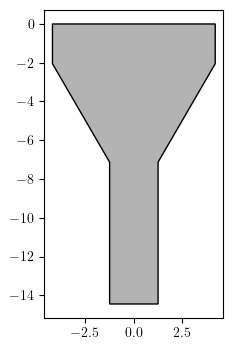

In [85]:
x_undeformed, y_undeformed = get_scaled_geom(a_list, d_in, d_out)

fig, ax = plt.subplots(figsize=(fig_h, fig_w))
ax.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
ax.set_aspect('equal')

In [ ]:
# Dummy data. delete later
# A_MEEM_corrected = A_BEM
# A_MEEM = A_MEEM_corrected
# B_MEEM_corrected = B_BEM
# B_MEEM = B_MEEM_corrected

In [86]:
# Add code for converging slants here
num_regions = np.linspace(1,50,50)
A_BEM_con = 100 * np.ones_like(num_regions)
A_MEEM_con = 90 * np.ones_like(num_regions)
A_MEEM_corrected_con = 99 * np.ones_like(num_regions)

B_BEM_con = 100 * np.ones_like(num_regions)
B_MEEM_con = 90 * np.ones_like(num_regions)
B_MEEM_corrected_con = 99 * np.ones_like(num_regions)


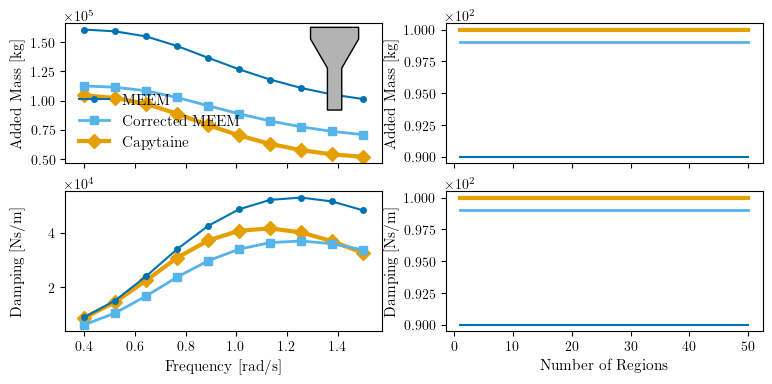

In [87]:
fig, ax = plt.subplots(2, 2, figsize=(fig_h, fig_w), sharex='col')
for a in ax.flat:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

ax[0,0].plot(omega_sweep, 
           A_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=3)
ax[0,0].plot(omega_sweep, 
           A_MEEM_corrected.squeeze(),
           marker='s', 
           linestyle='-', 
           color=colors.skyblue, 
           label='Corrected MEEM', 
           linewidth=l_width-1,
           markersize=m_size-1,
           zorder=2)
ax[0,0].plot(omega_sweep, 
           A_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)

# Add schematic of geometry
ax_ins = ax[0,0].inset_axes([0.65, 0.35, 0.4, 0.65])
ax_ins.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
ax_ins.set_aspect('equal')
ax_ins.set_xticks([])
ax_ins.set_yticks([])
ax_ins.axis('off') 

ax[0,0].set_xlim([x_min_lim, x_max_lim])
ax[0,0].set_ylabel('Added Mass [kg]', fontsize=lab_fs)
ax[0,0].legend(loc='lower left', fontsize=leg_fs, frameon=False)


ax[1,0].plot(omega_sweep, 
           B_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=3)
ax[1,0].plot(omega_sweep, 
           B_MEEM_corrected.squeeze(),
           marker='s', 
           linestyle='-', 
           color=colors.skyblue, 
           label='MEEM with Correction', 
           linewidth=l_width-1,
           markersize=m_size-1,
           zorder=2)
ax[1,0].plot(omega_sweep, 
           B_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[1,0].set_xlim([x_min_lim, x_max_lim])
ax[1,0].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1,0].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)



ax[0,1].plot(num_regions, 
           A_MEEM_con.squeeze(),
           marker='', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=3)
ax[0,1].plot(num_regions, 
           A_MEEM_corrected_con.squeeze(),
           marker='', 
           linestyle='-', 
           color=colors.skyblue, 
           label='MEEM with Correction', 
           linewidth=l_width-1,
           markersize=m_size-1,
           zorder=2)
ax[0,1].plot(num_regions, 
           A_BEM_con.squeeze(), 
           marker='',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size+1,
           zorder=1)
ax[0,1].set_ylabel('Added Mass [kg]', fontsize=lab_fs)




ax[1,1].plot(num_regions, 
           B_MEEM_con.squeeze(),
           marker='', 
           linestyle='-', 
           color=colors.blue, 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=3)
ax[1,1].plot(num_regions, 
           B_MEEM_corrected_con.squeeze(),
           marker='', 
           linestyle='-', 
           color=colors.skyblue, 
           label='MEEM with Correction', 
           linewidth=l_width-1,
           markersize=m_size-1,
           zorder=2)
ax[1,1].plot(num_regions, 
           B_BEM_con.squeeze(), 
           marker='',
           linestyle='-', 
           color=colors.orange, 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size+1,
           zorder=1)
ax[1,1].set_xlabel('Number of Regions', fontsize=lab_fs)
ax[1,1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)



fig.align_ylabels()

full_path = r"C:\Users\15183\OpenFLASH\pubs\JFM\figs\MEEM_vs_Capytaine_Slant_Validation_and_Convergence.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')